
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>


# Diving into the Transformer - Building your own Foundation LLM

This lesson introduces the underlying structure of transformers from token management to the layers in a decoder, to comparing smaller and larger models. We will build up all of the steps needed to create our foundation model before training. You will see how the layers are constructed, and how the next word is chosen. 

### ![Dolly](https://files.training.databricks.com/images/llm/dolly_small.png) Learning Objectives
1. Identify the key structures and functions in decoder transformers
1. Analyze the effect of hyperparameter changes (such as embedding dimension) on the size of the LLM
1. Compare the different performance of models with different model architectures

🖥️ Fuente extra [**Understanding and Coding the Self-Attention Mechanism of Large Language Models From Scratch**]: https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html <br>
📙 Deep Learning with Python book: 11.4 The Transformer architecture
🖥️ Otra fuente: https://e2eml.school/transformers.html 


## Classroom Setup

In [5]:
#%run ../Includes/Classroom-Setup

In [55]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import numpy as np
import matplotlib.pyplot as plt
#import seaborn

### PyTorch version of EMBEDDING layer:
    
''' nn.Embedding(numb_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2., scale_grad_by_freq=False, sparse=False, _weight=None) '''

* num_embeddings: the size of the dictionary of embeddings, the number of embeddings
* embedding_dim: the size of each embedding vector e.g. 16, 32
* padding_idx: the position of the "<PAD>" token in the vocabulary, if any
* max_norm: maximum norm of the word embedding in the embedding matrix
* norm_type: type of p-norm used to compute the norm over embeddings, by default 2 (euclidean distance)
* scale_grad_by_freq: Boolean indicating whether to scale the gradients by the word frequency
* sparse: boolean to decide whether to allocate sparse tensor of dense tensor
* _weight: initial weights for the embeddings, can be None for the default initializer

### Tensorflow Keras version of EMBEDDING layer:

from tensorflow.keras.layers import Embedding

➡️ Define Keras Embedding layer which is equivalent to PyTorch nn.Embedding layer <br>
''' keras_embedding = Embedding(input_dim=num_embeddings, output_dim=embedding_dim, input_length=max_len, mask_zero=True) '''

* num_embeddings: the size of the dictionary of embeddings, the number of embeddings
* embedding_dim: the size of each embedding vector e.g. 16, 32
* max_len: maximum length of sequence
* mask_zero: boolean for whether or not input value 0 is a special "padding" value that should be masked out

➡️ Convert text to indices
padded_input_ids = tf.keras.preprocessing.sequence.pad_sequences([[word2id[word] for word in sentence.split()]], maxlen=max_len, padding='post')

👉🏼 Get word embeddings
keras_word_embeddings = keras_embedding(padded_input_ids)


# Section 1: Encoding Natural Language - Word Embedding and Positional Encoding

In this section we'll look at how to take a natural language input and convert it to the form we'll need for our transformer.

In [56]:
#MY CODE
import llms_utils 

utils_obj = llms_utils.TextUtils()

In [57]:
#MY CODE
# Define a sentence and a simple word2id mapping
sentence = "The quick brown fox jumps over the lazy dog"

word2id = utils_obj.build_word2id_dict(sentence)
word2id

{'lazy': 0,
 'quick': 1,
 'fox': 2,
 'the': 3,
 'jumps': 4,
 'over': 5,
 'The': 6,
 'brown': 7,
 'dog': 8}

#### Utilizamos la tarjeta gráfica de MAC

In [58]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


#### Instanciamos la semilla

In [59]:
torch.manual_seed(42)

In [60]:
# Define a sentence and a simple word2id mapping
sentence = "The quick brown fox jumps over the lazy dog"

word2id = {word: i for i, word in enumerate(set(sentence.split()))}
print(word2id)
# Convert text to indices
input_ids = torch.tensor([word2id[word] for word in sentence.split()])
print(input_ids)
# Define a simple word embedding function
def get_word_embeddings(input_ids, embedding_size):
    embedding_layer = nn.Embedding(input_ids.max() + 1, embedding_size) #, device=device)
    return embedding_layer(input_ids)


# Get word embeddings
embedding_size = 16  # Size of the word embeddings
word_embeddings = get_word_embeddings(input_ids, embedding_size)
print(word_embeddings)

{'lazy': 0, 'quick': 1, 'fox': 2, 'the': 3, 'jumps': 4, 'over': 5, 'The': 6, 'brown': 7, 'dog': 8}
tensor([6, 1, 7, 2, 4, 5, 3, 0, 8])
tensor([[-2.5095e+00,  4.8800e-01,  7.8459e-01,  2.8647e-02,  6.4076e-01,
          5.8325e-01,  1.0669e+00, -4.5015e-01, -1.8527e-01,  7.5276e-01,
          4.0476e-01,  1.7847e-01,  2.6491e-01,  1.2732e+00, -1.3109e-03,
         -3.0360e-01],
        [ 1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01, -7.5813e-01,
          1.0783e+00,  8.0080e-01,  1.6806e+00,  1.2791e+00,  1.2964e+00,
          6.1047e-01,  1.3347e+00, -2.3162e-01,  4.1759e-02, -2.5158e-01,
          8.5986e-01],
        [-1.4570e+00, -1.0234e-01, -5.9915e-01,  4.7706e-01,  7.2618e-01,
          9.1152e-02, -3.8907e-01,  5.2792e-01, -1.2685e-02,  2.4084e-01,
          1.3254e-01,  7.6424e-01,  1.0950e+00,  3.3989e-01,  7.1997e-01,
          4.1141e-01],
        [-1.3847e+00, -8.7124e-01, -2.2337e-01,  1.7174e+00,  3.1888e-01,
         -4.2452e-01,  3.0572e-01, -7.7459e-01, -1.5576e

### 📊 Ploteamos una proyección bidimensional de los word embeddings:

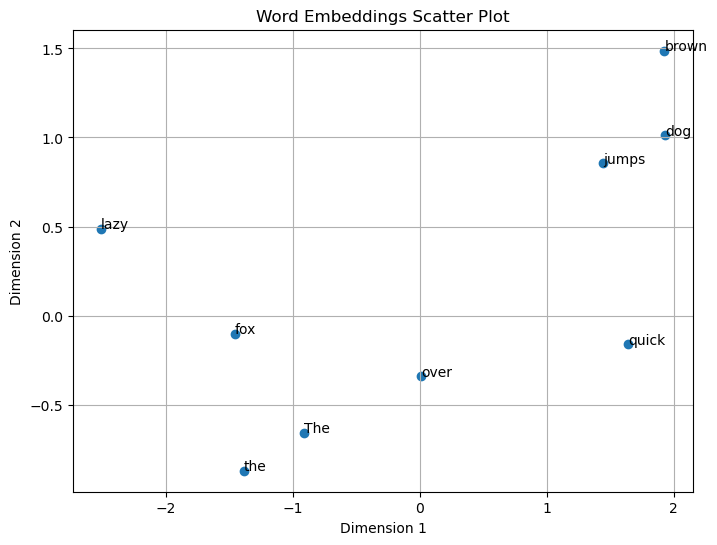

In [61]:
import matplotlib.pyplot as plt

words = [word for word in word2id.keys()]
word_embeddings_np = word_embeddings.detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter([e[0] for e in word_embeddings_np], [e[1] for e in word_embeddings_np])

for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_np[i][0], word_embeddings_np[i][1]))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Scatter Plot')
plt.grid(True)
plt.show()

📝 Y si indicamos las distancias euclídeas en un dataset?

In [62]:
import pandas as pd
from itertools import combinations
from scipy.spatial.distance import euclidean

# Obtén todas las combinaciones posibles de pares de palabras
word_pairs = list(combinations(word2id.keys(), 2))

# Calcula la distancia euclidiana entre los vectores de embedding de cada par de palabras
distances = [euclidean(word_embeddings.detach().numpy()[word2id[pair[0]]], word_embeddings.detach().numpy()[word2id[pair[1]]])
             for pair in word_pairs]

# Crea el DataFrame con las columnas "words_pair" y "euclidean distance"
df = pd.DataFrame({'words_pair': word_pairs, 'euclidean distance': distances})

# Imprime el DataFrame
df_sorted = df.sort_values(by='euclidean distance', ascending=False)
df_sorted

,words_pair,euclidean distance
26,"(jumps, over)",6.836809
25,"(the, dog)",6.745622
24,"(the, brown)",6.725553
13,"(quick, brown)",6.616878
9,"(quick, the)",6.585956
19,"(fox, brown)",6.580295
33,"(The, brown)",6.561934
6,"(lazy, brown)",6.438316
21,"(the, jumps)",6.375340
7,"(lazy, dog)",6.226408


#### repito ejecución para comprobar si esos embeddings de nn.Embedding() son deterministas:

In [63]:
print(word2id)
# Convert text to indices
input_ids = torch.tensor([word2id[word] for word in sentence.split()])
print(input_ids)
# Define a simple word embedding function
def get_word_embeddings(input_ids, embedding_size):
    embedding_layer = nn.Embedding(input_ids.max() + 1, embedding_size)
    return embedding_layer(input_ids)

# Get word embeddings
embedding_size = 16  # Size of the word embeddings
word_embeddings = get_word_embeddings(input_ids, embedding_size)
print(word_embeddings)

{'lazy': 0, 'quick': 1, 'fox': 2, 'the': 3, 'jumps': 4, 'over': 5, 'The': 6, 'brown': 7, 'dog': 8}
tensor([6, 1, 7, 2, 4, 5, 3, 0, 8])
tensor([[-0.9291,  0.2762, -0.5389,  0.4626, -0.8719, -0.0271, -0.3532,  1.4639,
          1.2554, -0.7150,  0.8539,  0.5130,  0.5397,  0.5655,  0.5058,  0.2225],
        [-1.9006,  0.2286,  0.0249, -0.3460,  0.2868, -0.7308,  0.1748, -1.0939,
         -1.6022,  1.3529,  1.2888,  0.0523, -1.5469,  0.7567,  0.7755,  2.0265],
        [-0.6855,  0.5636, -1.5072, -1.6107, -1.4790,  0.4323, -0.1250,  0.7821,
         -1.5988, -0.1091,  0.7152,  0.0391,  1.3059,  0.2466, -1.9776,  0.0179],
        [ 0.0358,  0.1206, -0.8057, -0.2076, -0.9319, -1.5910, -1.1360, -0.5226,
         -0.5188, -1.5013, -1.9267,  0.1279,  1.0229, -0.5558,  0.7043,  0.7099],
        [-0.8146, -1.0212, -0.4949, -0.5923,  0.1543,  0.4408, -0.1483, -2.3184,
         -0.3980,  1.0805, -1.7809,  1.5080,  0.3094, -0.5003,  1.0350,  1.6896],
        [-0.0045,  1.6668,  0.1539, -1.0603, -0.57

In [64]:
# embedding_layer = nn.Embedding(input_ids.max() + 1, embedding_size)
# embedding_layer.from_pretrained()

### 📊 Ploteamos una proyección bidimensional de los word embeddings:

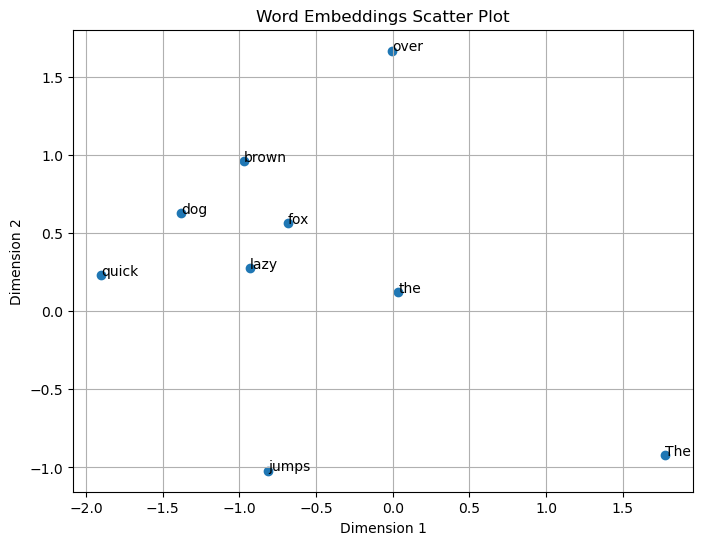

In [65]:
import matplotlib.pyplot as plt

words = [word for word in word2id.keys()]
word_embeddings_np = word_embeddings.detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter([e[0] for e in word_embeddings_np], [e[1] for e in word_embeddings_np])

for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_np[i][0], word_embeddings_np[i][1]))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Scatter Plot')
plt.grid(True)
plt.show()

📝 Y si indicamos las distancias euclídeas en un dataset?

In [66]:
import pandas as pd
from itertools import combinations
from scipy.spatial.distance import euclidean

# Obtén todas las combinaciones posibles de pares de palabras
word_pairs = list(combinations(word2id.keys(), 2))

# Calcula la distancia euclidiana entre los vectores de embedding de cada par de palabras
distances = [euclidean(word_embeddings.detach().numpy()[word2id[pair[0]]], word_embeddings.detach().numpy()[word2id[pair[1]]])
             for pair in word_pairs]

# Crea el DataFrame con las columnas "words_pair" y "euclidean distance"
df = pd.DataFrame({'words_pair': word_pairs, 'euclidean distance': distances})

# Imprime el DataFrame
df_sorted = df.sort_values(by='euclidean distance', ascending=False)
df_sorted

,words_pair,euclidean distance
19,"(fox, brown)",6.964108
35,"(brown, dog)",6.612442
33,"(The, brown)",6.604820
11,"(quick, over)",6.548141
25,"(the, dog)",6.468341
26,"(jumps, over)",6.452065
18,"(fox, The)",6.449695
16,"(fox, jumps)",6.445024
24,"(the, brown)",6.428621
32,"(over, dog)",6.407978


❓La proyección bidimensional no parece ir acorde a las distancias euclídeas (mirar el caso (over, quick))

## ❗️ Probar con más vocabulario o con pretrained embeddings ❗️

In [67]:
import torch
import torchtext
import torch.nn as nn

# Carga los embeddings pre-entrenados
pretrained_embeddings = torchtext.vocab.GloVe(name='6B', dim=300)

# Obtiene el vector de una palabra específica
word_vector = pretrained_embeddings['The'].unsqueeze(0)
word_vector


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

➡️ contiene todo 0s porque no contiene esa palabra, sino la lower cased:

In [68]:
word_vector = pretrained_embeddings['the'].unsqueeze(0)
word_vector

tensor([[ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
          2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
         -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
          2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
         -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
         -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
          9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
         -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
          1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
          2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
          1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
          2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
         -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
         -4.4640e-01,  1.7197e-01,  4.

### 💡 ❓Tardaría mucho menos usando una base de datos vectorial que ya contenga esos embeddings? To check con Databricks? 💡💡💡 <p>

#### Ahora repetimos el análisis de similitud de palabras de antes con estos embeddings pre-entrenados:

In [69]:
import pandas as pd
from itertools import combinations
from scipy.spatial.distance import euclidean

# Obtén todas las combinaciones posibles de pares de palabras
word_pairs = list(combinations(word2id.keys(), 2))

# Carga los embeddings pre-entrenados
pretrained_embeddings = torchtext.vocab.GloVe(name='6B', dim=300)

# Calcula la distancia euclidiana entre los vectores de embedding de cada par de palabras
distances = [euclidean(pretrained_embeddings[pair[0]], pretrained_embeddings[pair[1]])
             for pair in word_pairs]

# Crea el DataFrame con las columnas "words_pair" y "euclidean distance"
df = pd.DataFrame({'words_pair': word_pairs, 'euclidean distance': distances})

# Imprime el DataFrame
df_sorted = df.sort_values(by='euclidean distance', ascending=False)
df_sorted

,words_pair,euclidean distance
4,"(lazy, over)",8.471087
28,"(jumps, brown)",8.466522
2,"(lazy, the)",8.266583
16,"(fox, jumps)",8.260901
29,"(jumps, dog)",8.121976
32,"(over, dog)",8.059059
1,"(lazy, fox)",8.041628
6,"(lazy, brown)",8.015525
26,"(jumps, over)",7.997568
35,"(brown, dog)",7.942396


In [70]:
import pandas as pd
from itertools import combinations

# Obtén todas las combinaciones posibles de pares de palabras
word_pairs = list(combinations(word2id.keys(), 2))

# Carga los embeddings pre-entrenados
pretrained_embeddings = torchtext.vocab.GloVe(name='6B', dim=300)

# Calcula la distancia euclidiana entre los vectores de embedding de cada par de palabras
distances = [torch.cosine_similarity(pretrained_embeddings[pair[0]].unsqueeze(0), 
                                     pretrained_embeddings[pair[1]].unsqueeze(0))
             for pair in word_pairs]

# Crea el DataFrame con las columnas "words_pair" y "euclidean distance"
df = pd.DataFrame({'words_pair': word_pairs, 'cosine similarity': distances})

# Imprime el DataFrame
df_sorted = df.sort_values(by='cosine similarity', ascending=False)
df_sorted

,words_pair,cosine similarity
22,"(the, over)",[tensor(0.5247)]
7,"(lazy, dog)",[tensor(0.3721)]
19,"(fox, brown)",[tensor(0.3576)]
0,"(lazy, quick)",[tensor(0.3124)]
31,"(over, brown)",[tensor(0.3123)]
20,"(fox, dog)",[tensor(0.3036)]
24,"(the, brown)",[tensor(0.2825)]
10,"(quick, jumps)",[tensor(0.2801)]
9,"(quick, the)",[tensor(0.2688)]
13,"(quick, brown)",[tensor(0.2539)]


### 👓 Ahora probamos a representar gráficamente los embeddings proyectados en 2-D

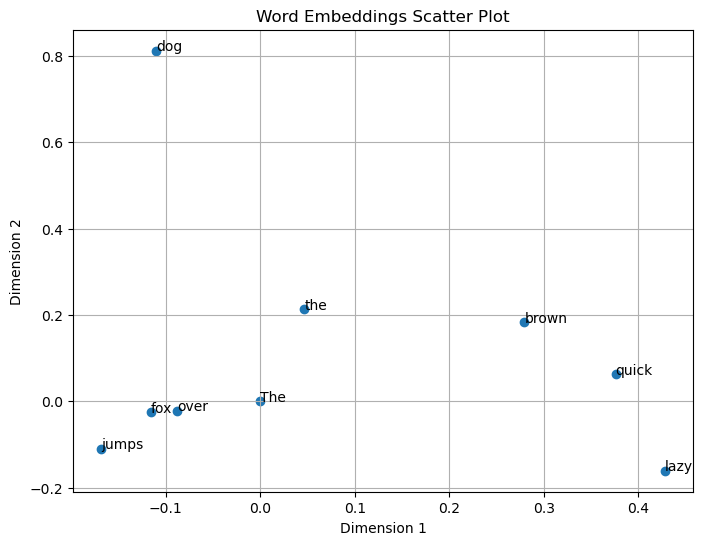

In [71]:
import matplotlib.pyplot as plt

words = [word for word in word2id.keys()]
word_embeddings_np = [pretrained_embeddings[word].unsqueeze(0)[0] for word in words] #word_embeddings.detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter([e[0] for e in word_embeddings_np], [e[1] for e in word_embeddings_np])

for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_np[i][0], word_embeddings_np[i][1]))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Scatter Plot')
plt.grid(True)
plt.show()

✅ En cambio, si obtenemos los embeddings del BertModel (con "bert-base-uncased") parece tener más sentido, al menos con estas palabras:

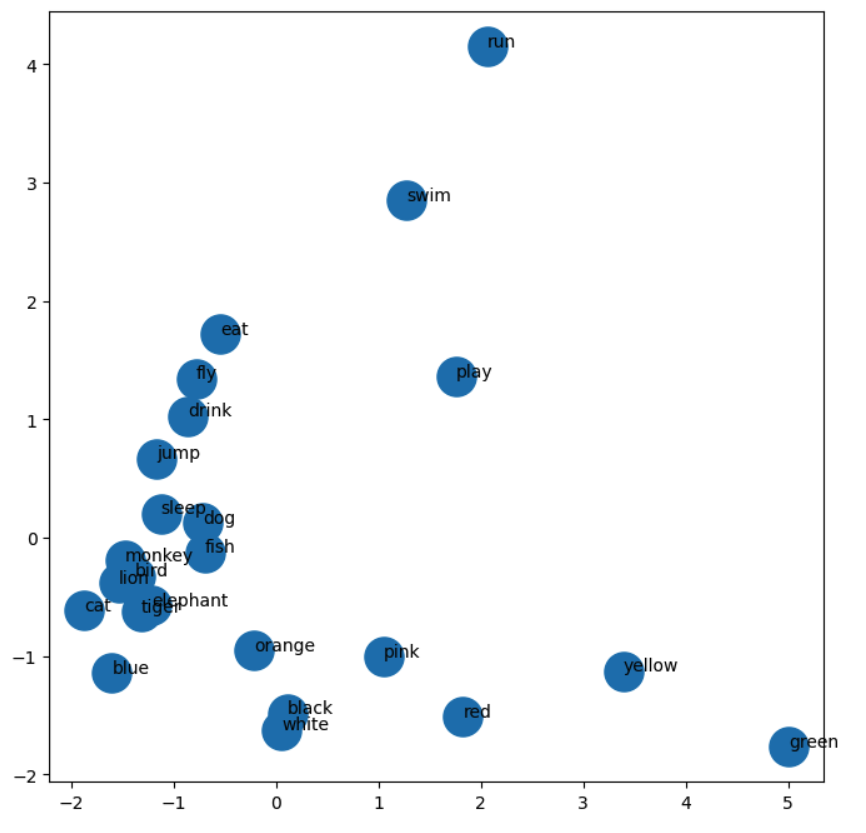

📙Construimos clase helper para librería de la funcionalidad generada:

In [74]:
import pandas as pd
from itertools import combinations
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torchtext
import torch.nn as nn

class NLPHelper:
    def __init__(self):
        """
        Inicializa la clase NLPHelper.
        Carga los embeddings pre-entrenados.
        """
        self.pretrained_embeddings = torchtext.vocab.GloVe(name='6B', dim=300)
    
    def build_word2id(self, sentence):
        """
        Construye el diccionario word2id a partir de una oración.
        
        Args:
            sentence (str): La oración de entrada.
        
        Returns:
            dict: El diccionario word2id.
        """
        try:
            words = sentence.split()
            word2id = {word: i for i, word in enumerate(set(words))}
            return word2id
        except Exception as e:
            print(f"Error al construir el diccionario word2id: {e}")
    
    def build_id2word(self, word2id):
        """
        Construye el diccionario id2word a partir del diccionario word2id.
        
        Args:
            word2id (dict): El diccionario word2id.
        
        Returns:
            dict: El diccionario id2word.
        """
        try:
            id2word = {i: word for word, i in word2id.items()}
            return id2word
        except Exception as e:
            print(f"Error al construir el diccionario id2word: {e}")
    
    def get_word_vector(self, word):
        """
        Obtiene el vector de embedding de una palabra específica.
        
        Args:
            word (str): La palabra de entrada.
        
        Returns:
            torch.Tensor: El vector de embedding de la palabra.
        """
        try:
            word_vector = self.pretrained_embeddings[word].unsqueeze(0)
            return word_vector
        except Exception as e:
            print(f"Error al obtener el vector de la palabra: {e}")
    
    def process_text(self, text):
        """
        Procesa un texto dado.
        
        Args:
            text (str): El texto de entrada.
        
        Returns:
            str: El texto procesado.
        """
        try:
            processed_text = text.lower()
            return processed_text
        except Exception as e:
            print(f"Error al procesar el texto: {e}")
    
    def build_distance_dataset(self, word2id):
        """
        Construye el dataset de distancias euclidianas y similitud coseno a partir del diccionario word2id.
        
        Args:
            word2id (dict): El diccionario word2id.
        
        Returns:
            pd.DataFrame: El dataset de distancias.
        """
        try:
            word_pairs = list(combinations(word2id.keys(), 2))
            euclidean_distances = [euclidean(self.pretrained_embeddings[pair[0]].numpy(), self.pretrained_embeddings[pair[1]].numpy())
                                   for pair in word_pairs]
            cosine_similarities = [cosine_similarity(self.pretrained_embeddings[pair[0]].unsqueeze(0), self.pretrained_embeddings[pair[1]].unsqueeze(0)).item()
                                   for pair in word_pairs]
            df = pd.DataFrame({'words_pair': word_pairs, 'euclidean distance': euclidean_distances, 'cosine similarity': cosine_similarities})
            return df
        except Exception as e:
            print(f"Error al construir el dataset de distancias: {e}")

# Ejemplo de uso de la clase NLPHelper
nlp_helper = NLPHelper()

# Construir el diccionario word2id
sentence = "The quick brown fox jumps over the lazy dog"
word2id = nlp_helper.build_word2id(sentence)

# Construir el dataset de distancias euclidianas y similitud coseno
distance_dataset = nlp_helper.build_distance_dataset(word2id).sort_values(by='cosine similarity', ascending=False)
print("Dataset de distancias:")
print(distance_dataset)

Dataset de distancias:
        words_pair  euclidean distance  cosine similarity
22     (the, over)            5.415083           0.524727
7      (lazy, dog)            7.324604           0.372058
19    (fox, brown)            7.157426           0.357643
0    (lazy, quick)            7.162558           0.312430
31   (over, brown)            7.035670           0.312257
20      (fox, dog)            7.767117           0.303579
24    (the, brown)            6.818565           0.282550
10  (quick, jumps)            7.242292           0.280133
9     (quick, the)            6.655501           0.268772
13  (quick, brown)            7.289819           0.253946
3    (lazy, jumps)            7.739300           0.251787
11   (quick, over)            7.185765           0.239928
35    (brown, dog)            7.942396           0.232761
14    (quick, dog)            7.777961           0.227852
25      (the, dog)            7.458118           0.227808
1      (lazy, fox)            8.041628           

In [75]:
import unittest

# Clase de pruebas unitarias para la clase NLPHelper
class NLPHelperTests(unittest.TestCase):
    def setUp(self):
        self.nlp_helper = NLPHelper()
    
    def test_build_word2id(self):
        sentence = "The quick brown fox jumps over the lazy dog"
        word2id = self.nlp_helper.build_word2id(sentence)
        self.assertIsInstance(word2id, dict)
        self.assertEqual(len(word2id), 8)
    
    def test_build_id2word(self):
        word2id = {'The': 0, 'quick': 1, 'brown': 2, 'fox': 3, 'jumps': 4, 'over': 5, 'the': 6, 'lazy': 7, 'dog': 8}
        id2word = self.nlp_helper.build_id2word(word2id)
        self.assertIsInstance(id2word, dict)
        self.assertEqual(len(id2word), 9)
    
    def test_get_word_vector(self):
        word = 'quick'
        word_vector = self.nlp_helper.get_word_vector(word)
        self.assertIsInstance(word_vector, torch.Tensor)
        self.assertEqual(word_vector.shape, torch.Size([1, 300]))
    
    def test_process_text(self):
        text = "The Quick Brown Fox"
        processed_text = self.nlp_helper.process_text(text)
        self.assertIsInstance(processed_text, str)
        self.assertEqual(processed_text, "the quick brown fox")
    
    def test_build_distance_dataset(self):
        self.setUp()
        word2id = {'The': 0, 'quick': 1, 'brown': 2, 'fox': 3, 'jumps': 4, 'over': 5, 'the': 6, 'lazy': 7, 'dog': 8}
        distance_dataset = self.nlp_helper.build_distance_dataset(word2id)
        #print('distance dataset: ', distance_dataset)
        self.assertIsInstance(distance_dataset, pd.DataFrame)
        self.assertEqual(distance_dataset.shape[0], 36)
        self.assertEqual(distance_dataset.shape[1], 3)

        self.distance_dataset = distance_dataset

        # Validación adicional de la funcionalidad
        similar_pair = ('fox', 'dog')
        dissimilar_pair = ('the', 'dog')
        
        similar_distance = distance_dataset[distance_dataset['words_pair'] == similar_pair]['euclidean distance'].values[0]
        dissimilar_distance =distance_dataset[distance_dataset['words_pair'] == dissimilar_pair]['euclidean distance'].values[0]
        
        self.assertGreater(similar_distance, dissimilar_distance)

# Ejecutar][as pruebas unitarias
'''
if __name__ == '__main__':
    unittest.main()'''
tester_obj = NLPHelperTests()
tester_obj.test_build_distance_dataset()

tester_obj.distance_dataset

,words_pair,euclidean distance,cosine similarity
0,"(The, quick)",5.795814,0.000000
1,"(The, brown)",6.131897,0.000000
2,"(The, fox)",6.486977,0.000000
3,"(The, jumps)",6.259912,0.000000
4,"(The, over)",5.860192,0.000000
5,"(The, the)",5.181397,0.000000
6,"(The, lazy)",6.392241,0.000000
7,"(The, dog)",6.673080,0.000000
8,"(quick, brown)",7.289819,0.253946
9,"(quick, fox)",7.831755,0.190651


👉🏼 Podemos comprobar que, según la métrica seleccionada, el orden de pares de palabras según su similitud semántica difiere; a primera vista, de manera rápida, parece tener más sentido _cosine similarity_

🧱 seguimos con el notebook de Databricks

In [77]:
# Define a function to generate positional encodings
def get_positional_encoding(max_seq_len, d_model):
    position = np.arange(max_seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    positional_encoding = np.zeros((max_seq_len, d_model))
    positional_encoding[:, 0::2] = np.sin(position * div_term)
    positional_encoding[:, 1::2] = np.cos(position * div_term)
    return torch.tensor(positional_encoding, dtype=torch.float)


In [78]:
np.arange(len(sentence.split()))[:, np.newaxis]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8]])

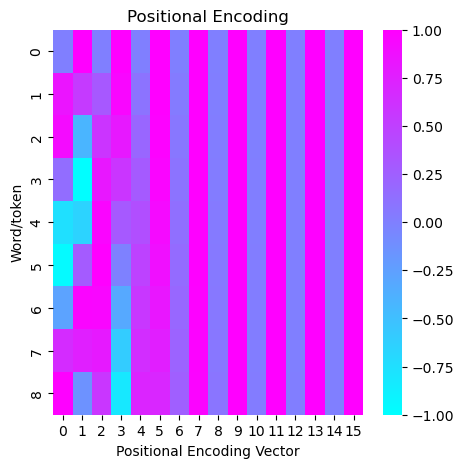

In [79]:
import seaborn as sns

# Function to plot heatmap
# ------------------------
def plot_heatmap(data, title):
    plt.figure(figsize=(5,5))
    sns.heatmap(data, cmap="cool",vmin=-1, vmax=1)
    plt.ylabel("Word/token")
    plt.xlabel("Positional Encoding Vector")
    plt.title(title)
    plt.show()

# Generate and plot positional encoding
# -------------------------------------
# Get positional encodings
max_seq_len = len(sentence.split())  # Maximum sequence length
d_model = embedding_size  # Same as the size of the word embeddings
positional_encodings = get_positional_encoding(max_seq_len, d_model)
plot_heatmap(positional_encodings, "Positional Encoding")

## Interpreting the Positional Encoding Map
In the Transformer model, positional encoding is used to give the model some information about the relative positions of the words in the sequence since the Transformer does not have any inherent sense of order of the input sequence.

The positional encoding for a position \(p\) in the sequence and a dimension \(i\) in the embedding space is a mix of sine and cosine functions:


$$PE_{(p, 2i)} = \sin\left(\frac{p}{10000^{2i/d}}\right)$$



$$PE_{(p, 2i+1)} = \cos\left(\frac{p}{10000^{2i/d}}\right)$$


Here, \\(d\\) is the dimension of the word embedding.

These functions were chosen because they can provide a unique encoding for each word position and these encodings can be easily learned and extrapolated for sequence lengths not seen during training.

In the heatmap:

- The x-axis represents the dimension of the embedding space. Every pair of dimensions \\((2i, 2i+1)\\) corresponds to a specific frequency of the sine and cosine functions.

- The y-axis represents the position of a word in the sequence.

- The color at each point in the heatmap represents the value of the positional encoding at that position and dimension. Typically, a warmer color (like red) represents a higher value and a cooler color (like blue) represents a lower value.

By visualizing the positional encodings in a heatmap, we can see how these values change across positions and dimensions, and get an intuition for how the Transformer model might use these values to understand the order of words in the sequence.

In [80]:
# Get positional encodings
max_seq_len = len(sentence.split())  # Maximum sequence length
d_model = embedding_size  # Same as the size of the word embeddings
positional_encodings = get_positional_encoding(max_seq_len, d_model)

# Add word embeddings and positional encodings
final_embeddings = word_embeddings + positional_encodings

print(final_embeddings)

tensor([[-0.9291,  1.2762, -0.5389,  1.4626, -0.8719,  0.9729, -0.3532,  2.4639,
          1.2554,  0.2850,  0.8539,  1.5130,  0.5397,  1.5655,  0.5058,  1.2225],
        [-1.0591,  0.7689,  0.3358,  0.6045,  0.3867,  0.2642,  0.2064, -0.0944,
         -1.5922,  2.3528,  1.2920,  1.0523, -1.5459,  1.7567,  0.7758,  3.0265],
        [ 0.2238,  0.1474, -0.9160, -0.8041, -1.2804,  1.4123, -0.0618,  1.7801,
         -1.5788,  0.8907,  0.7215,  1.0391,  1.3079,  1.2466, -1.9770,  1.0179],
        [ 0.1769, -0.8694,  0.0070,  0.3752, -0.6364, -0.6356, -1.0412,  0.4729,
         -0.4888, -0.5017, -1.9172,  1.1278,  1.0259,  0.4442,  0.7052,  1.7099],
        [-1.5714, -1.6749,  0.4587, -0.2911,  0.5437,  1.3618, -0.0221, -1.3264,
         -0.3580,  2.0797, -1.7682,  2.5080,  0.3134,  0.4997,  1.0363,  2.6896],
        [-0.9634,  1.9505,  1.1539, -1.0706, -0.0932,  0.9612,  0.5574,  2.9767,
         -0.0220,  0.0927, -2.0329, -0.0812,  0.0226,  1.0782,  0.1947,  1.4097],
        [ 1.4950,  0.0

# Section 2: Building Our Own Decoder From Scratch

Let's now build a decoder transformer. We'll build up the code from scratch and build a single layer transformer.

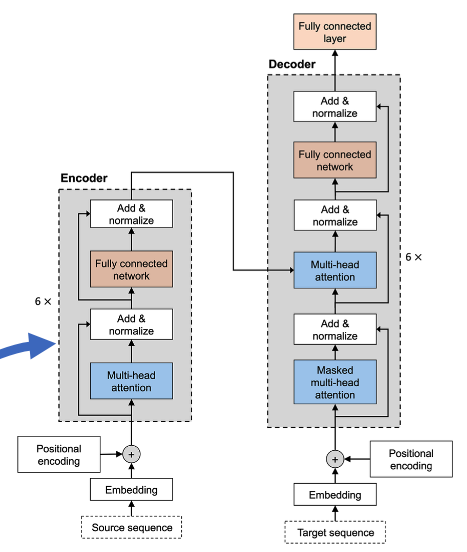

#### implementado así (abajo en código):
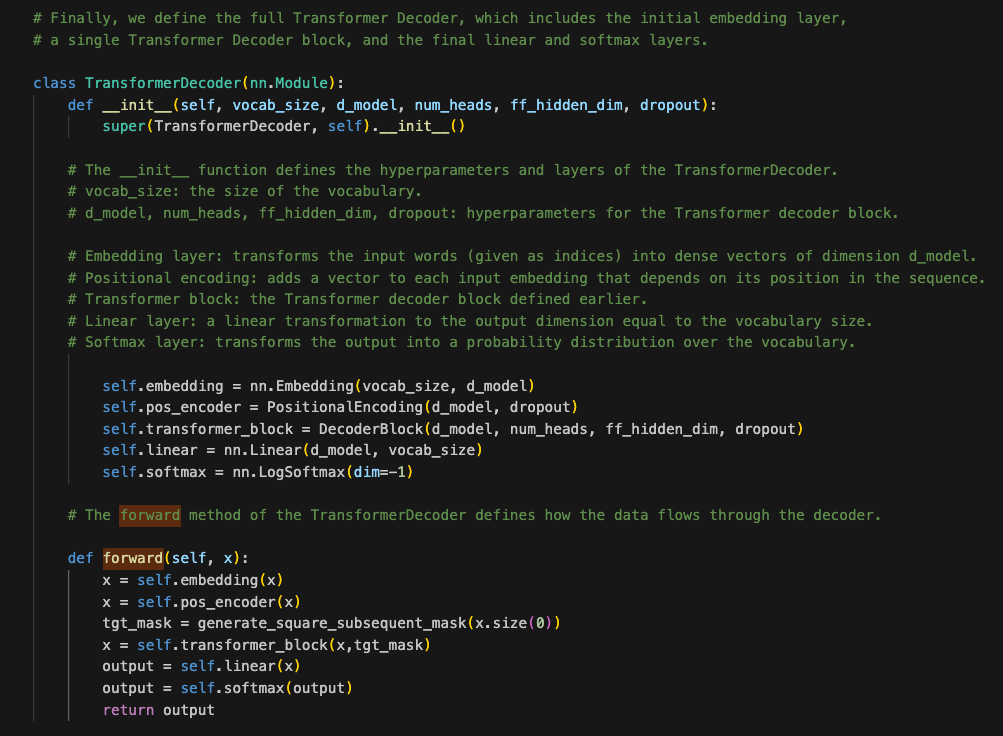

In [81]:
# Here we define the DecoderBlock, which is a single layer of the Transformer Decoder.

class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout):
        super(DecoderBlock, self).__init__()

    # The first part of the __init__ function defines the hyperparameters for the DecoderBlock.
    # d_model: the dimension of the input vector.
    # num_heads: the number of heads in the multihead attention mechanism.
    # ff_hidden_dim: the dimension of the feed forward hidden layer.
    # dropout: the dropout rate.

        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(d_model, ff_hidden_dim)
        self.linear2 = nn.Linear(ff_hidden_dim, d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    # The forward method defines how the data flows through the network.
    # It takes two inputs: x, tgt_mask.
    # x: the input tensor.
    # tgt_mask: masks to prevent attention to certain positions.

    def forward(self, x,tgt_mask):
        attn_output, _ = self.self_attention(x, x, x, attn_mask=tgt_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        ff_output = self.linear2(F.relu(self.linear1(x)))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

In [82]:
# Next, we define the PositionalEncoding class, which applies a specific positional encoding to give the model 
# information about the relative or absolute position of the tokens in the sequence.

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [83]:
def generate_square_subsequent_mask(sz):
    """Generate a mask to prevent attention to future positions."""
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [84]:
# Finally, we define the full Transformer Decoder, which includes the initial embedding layer, 
# a single Transformer Decoder block, and the final linear and softmax layers.

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, ff_hidden_dim, dropout):
        super(TransformerDecoder, self).__init__()

    # The __init__ function defines the hyperparameters and layers of the TransformerDecoder.
    # vocab_size: the size of the vocabulary.
    # d_model, num_heads, ff_hidden_dim, dropout: hyperparameters for the Transformer decoder block.

    # Embedding layer: transforms the input words (given as indices) into dense vectors of dimension d_model.
    # Positional encoding: adds a vector to each input embedding that depends on its position in the sequence.
    # Transformer block: the Transformer decoder block defined earlier.
    # Linear layer: a linear transformation to the output dimension equal to the vocabulary size.
    # Softmax layer: transforms the output into a probability distribution over the vocabulary.

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_block = DecoderBlock(d_model, num_heads, ff_hidden_dim, dropout)
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    # The forward method of the TransformerDecoder defines how the data flows through the decoder.

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        tgt_mask = generate_square_subsequent_mask(x.size(0))
        x = self.transformer_block(x,tgt_mask)
        output = self.linear(x)
        output = self.softmax(output)
        return output

### Why we need to mask our input for decoders

/Users/german_cm/anaconda3/envs/llms-pocs-env/lib/python3.9/site-packages/matplotlib/colors.py:1370: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/Users/german_cm/anaconda3/envs/llms-pocs-env/lib/python3.9/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


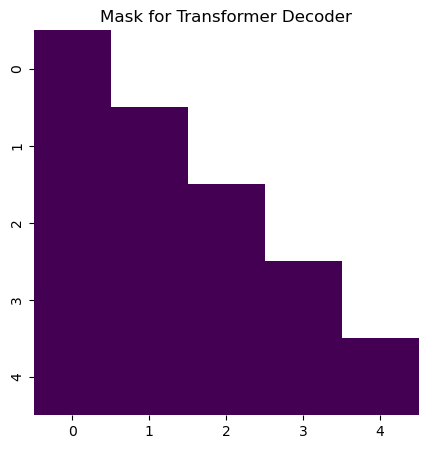

In [85]:
mask = generate_square_subsequent_mask(sz=5)

plt.figure(figsize=(5,5))
sns.heatmap(mask, cmap="viridis", cbar=False, square=True)
plt.title("Mask for Transformer Decoder")
plt.show()

### Let's make our first decoder

In [87]:
# Define the hyperparameters
vocab_size     = 1000
d_model        = 512
num_heads      = 1
ff_hidden_dim  = 2*d_model
dropout        = 0.1
num_layers     = 10
context_length = 50
batch_size     = 1
# Initialize the model
model = TransformerDecoder(vocab_size, d_model, num_heads, ff_hidden_dim, dropout)

# Create a tensor representing a batch of 1 sequences of length 10
input_tensor = torch.randint(0, vocab_size, (context_length, batch_size))
print('input tensor: ', input_tensor.squeeze())

# Forward pass through the model
output = model(input_tensor)

# The output is a tensor of shape (sequence_length, batch_size, vocab_size)
print(output.shape)  # Should print torch.Size([context_length, batch_size, vocab_size])
print('model output', output)

# To get the predicted word indices, we can use the `argmax` function
predicted_indices = output.argmax(dim=-1)

# Now `predicted_indices` is a tensor of shape (sequence_length, batch_size) containing the predicted word indices
print(predicted_indices.shape)  # Should print torch.Size([context_length, batch_size])


input tensor:  tensor([237, 751,  49, 442,  50, 122, 941, 622, 300,  15, 369, 319, 614, 653,
        843,  30, 943,  74, 837, 143, 543, 684,  21, 543, 394, 767, 374, 442,
        607, 560, 720, 193,  60, 879, 980,  27, 468, 245, 634, 523,  13, 685,
        947, 983, 815, 110, 157, 401, 664, 863])
torch.Size([50, 1, 1000])
model output tensor([[[-6.8873, -8.0190, -7.5008,  ..., -7.1501, -7.1940, -7.8210]],

        [[-7.4737, -8.2474, -7.2905,  ..., -6.5671, -6.6263, -8.1942]],

        [[-6.8116, -6.9114, -7.4408,  ..., -7.0613, -8.1006, -6.4913]],

        ...,

        [[-7.3572, -6.7872, -6.5947,  ..., -6.7928, -7.9636, -6.8987]],

        [[-7.0264, -6.8920, -8.4060,  ..., -6.6362, -7.2590, -7.6054]],

        [[-7.3331, -7.2482, -6.7036,  ..., -6.7014, -7.3639, -7.4022]]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([50, 1])


In [88]:
print('max word index of the first token in the output sentence: ', np.argmax(output[0][0].detach().numpy()))

print('predicted_indices: ', predicted_indices.squeeze())

max word index of the first token in the output sentence:  764
predicted_indices:  tensor([764, 198, 737,  88, 785, 113, 809, 308, 669, 226,  15, 770, 210, 913,
        105, 210, 762, 163, 236, 871, 585, 530, 854, 585, 243, 581,  56, 465,
        658,  35, 669, 469, 175, 212, 817, 875, 651, 871, 790, 290, 815, 660,
        783,  73,  82, 177, 863, 752, 713, 725])


Respuesta de Copilot sobre los hiperparámetros del modelo Transformer:

1. `vocab_size`: Este hiperparámetro representa el tamaño del vocabulario utilizado en el modelo. Indica la cantidad de palabras únicas que el modelo puede procesar. En este caso, se ha establecido en 1000, lo que significa que el modelo puede trabajar con un vocabulario de 1000 palabras.

2. `d_model`: Este hiperparámetro se refiere a la dimensión del espacio de representación utilizado por el modelo. Es el tamaño de los vectores de representación de palabras y también determina el tamaño de los vectores de salida del modelo. En este caso, se ha establecido en 512, lo que significa que el modelo utilizará vectores de 512 dimensiones para representar las palabras y generar las salidas.

3. `num_heads`: Este hiperparámetro indica el número de cabezas de atención que se utilizan en el modelo Transformer. La atención múltiple permite que el modelo se enfoque en diferentes partes de la secuencia de entrada de manera simultánea. En este caso, se ha establecido en 1, lo que significa que solo se utiliza una cabeza de atención.

4. `ff_hidden_dim`: Este hiperparámetro se refiere a la dimensión de la capa oculta en la red de alimentación hacia adelante (feed-forward) del modelo. Es el tamaño de los vectores de salida de la capa oculta. En este caso, se ha establecido en el doble de `d_model`, es decir, 2 * 512 = 1024.

5. `dropout`: Este hiperparámetro representa la probabilidad de que se aplique el dropout en las capas del modelo. El dropout es una técnica de regularización que ayuda a prevenir el sobreajuste al apagar aleatoriamente algunas neuronas durante el entrenamiento. En este caso, se ha establecido en 0.1, lo que significa que se aplica dropout con una probabilidad del 10%.

6. `num_layers`: Este hiperparámetro indica el número de capas en el modelo Transformer. Cada capa tiene subcapas de atención y redes de alimentación hacia adelante. En este caso, se ha establecido en 10, lo que significa que el modelo tiene 10 capas.

7. `context_length`: Este hiperparámetro se refiere a la longitud del contexto o secuencia de entrada que el modelo puede procesar. En este caso, se ha establecido en 50, lo que significa que el modelo puede procesar secuencias de hasta 50 palabras.

8. `batch_size`: Este hiperparámetro indica el tamaño del lote utilizado durante el entrenamiento del modelo. Es la cantidad de ejemplos de entrenamiento que se procesan juntos antes de actualizar los pesos del modelo. En este caso, se ha establecido en 1, lo que significa que se utiliza un solo ejemplo de entrenamiento a la vez.

Estos valores de hiperparámetros pueden variar según el problema y los datos específicos con los que se esté trabajando. Los valores elegidos en este caso pueden ser una configuración inicial o específica para el problema en cuestión.

Espero que esta explicación aclare el propósito de cada uno de los hiperparámetros en el modelo Transformer. Si tienes alguna otra pregunta, no dudes en hacerla.



In [89]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 3,127,784 trainable parameters


### Looking at the output

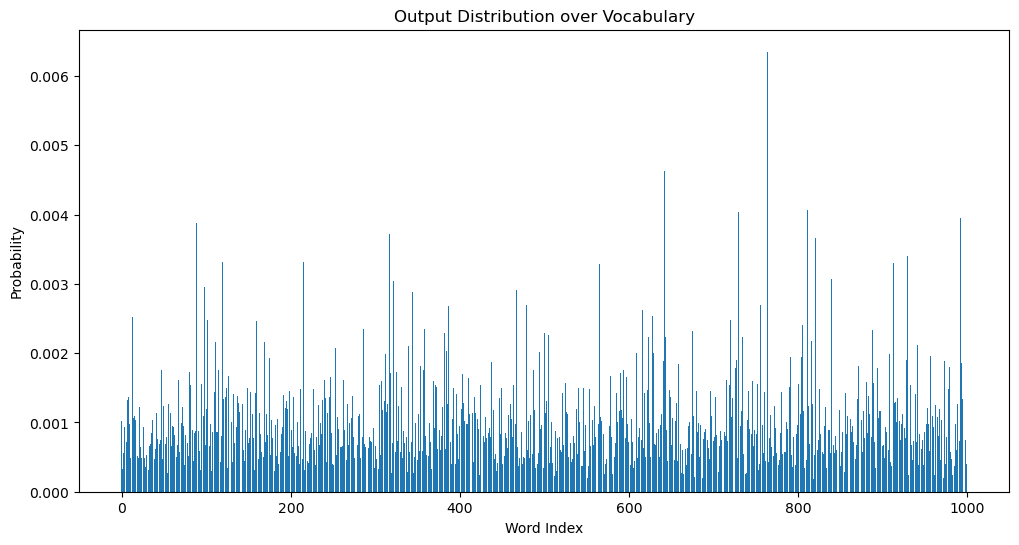

In [92]:
# Convert the log probabilities to probabilities
distribution = torch.exp(output[0, 0, :])

# Convert the output tensor to numpy array
distribution = distribution.detach().numpy()

# Now plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel("Word Index")
plt.ylabel("Probability")
plt.title("Output Distribution over Vocabulary")
plt.show()

# Section 3: Multi-layer Decoder

Let's allow for multiple layers in our decoder so we can form models like GPT

In [93]:
class MultiLayerTransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, ff_hidden_dim, dropout, num_layers):
        super(MultiLayerTransformerDecoder, self).__init__()

# The __init__ function now also takes a `num_layers` argument, which specifies the number of decoder blocks.

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, ff_hidden_dim, dropout)
            for _ in range(num_layers)
        ])
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

# The forward method has been updated to pass the input through each transformer block in sequence.

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        for transformer_block in self.transformer_blocks:
            tgt_mask = generate_square_subsequent_mask(x.size(0))
            x = transformer_block(x,tgt_mask)
        output = self.linear(x)
        output = self.softmax(output)
        return output


The model has 544,552,720 trainable parameters


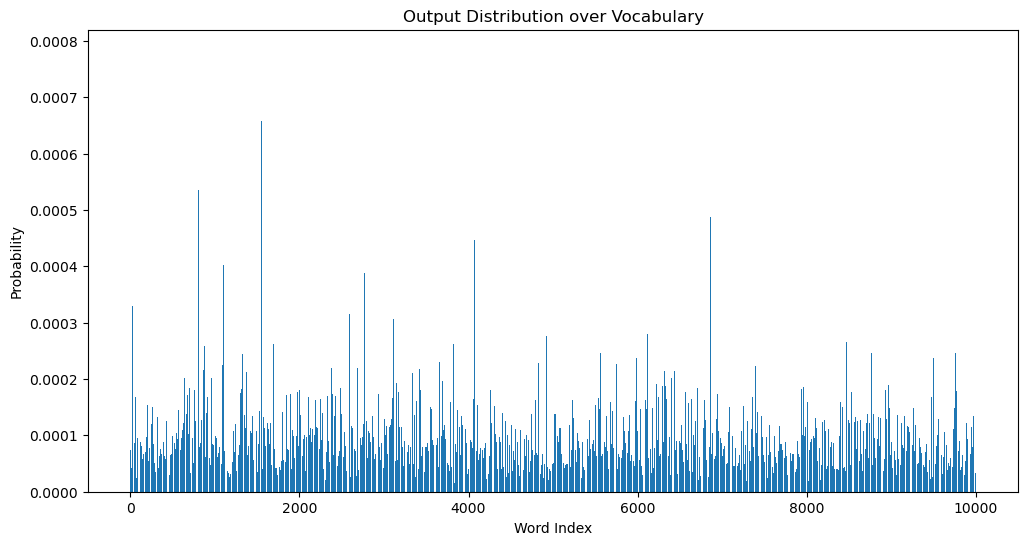

In [94]:
# Define the hyperparameters
vocab_size     = 10000
d_model        = 2048
num_heads      = 1
ff_hidden_dim  = 4*d_model
dropout        = 0.1
num_layers     = 10
context_length = 100
batch_size     = 1

# Create our input to the model to process
input_tensor = torch.randint(0, vocab_size, (context_length, batch_size))

# Initialize the model with `num_layer` layers
model = MultiLayerTransformerDecoder(vocab_size, d_model, num_heads, ff_hidden_dim, dropout, num_layers)

# Print the number of trainable parameters
print(f"The model has {count_parameters(model):,} trainable parameters")

# Let's use the same input_tensor from the previous example
output = model(input_tensor)

# Convert the log probabilities to probabilities for the first sequence in the batch and the first position in the sequence
distribution = torch.exp(output[0, 0, :])

# Convert the output tensor to numpy array
distribution = distribution.detach().numpy()

# Now plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel("Word Index")
plt.ylabel("Probability")
plt.title("Output Distribution over Vocabulary")
plt.show()

In [95]:
model

MultiLayerTransformerDecoder(
  (embedding): Embedding(10000, 2048)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0-9): 10 x DecoderBlock(
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=2048, out_features=2048, bias=True)
      )
      (norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (linear1): Linear(in_features=2048, out_features=8192, bias=True)
      (linear2): Linear(in_features=8192, out_features=2048, bias=True)
      (norm2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (linear): Linear(in_features=2048, out_features=10000, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

# Section 4: Adding real vocabulary to our model

Rather than just using a random integer, let's add in a small vocabulary of real words and let our model speak!

In [96]:
# Define the hyperparameters
d_model        = 100
num_heads      = 1
ff_hidden_dim  = 4*d_model
dropout        = 0.1
num_layers     = 4
context_length = 5
batch_size     = 1
# Define the vocabulary
vocab = ["of", "in", "to", "for", "with", "on", "at", "from", "by", "about", "as", "into", "like", "through", "after", "over", "between", "out", "against", "during", "without", "before", "under", "around", "among"]
vocab_size = len(vocab)

# Create a dictionary that maps words to indices
word2id = {word: id for id, word in enumerate(vocab)}

# Create a dictionary that maps indices to words
id2word = {id: word for id, word in enumerate(vocab)}

# Initialize the model
model = MultiLayerTransformerDecoder(vocab_size, d_model, num_heads, ff_hidden_dim, dropout, num_layers)

# Create a tensor representing a single sequence of variable length
# Here we randomly select words from our vocabulary
sequence = ["of", "in", "to", "for", "with", "on", "at"][:context_length]
input_tensor = torch.tensor([[word2id[word] for word in sequence]])

# Generate a sequence of words
generated_words = []
for i in range(10):  # Generate 10 words
    output = model(input_tensor)
    predicted_index = output.argmax(dim=-1)[0, -1]  # Take the last word in the sequence
    predicted_word = id2word[predicted_index.item()]
    print(predicted_word, end=" ")
    generated_words.append(predicted_word)
    input_tensor = torch.cat([input_tensor, predicted_index.unsqueeze(0).unsqueeze(0)], dim=-1)  # Append the predicted word to the input
    time.sleep(0.75)  # Pause for 1 second


at from under with out between at under at under 

# Section 5: Using a trained decoder and real-world vocabulary

Training our model will take a long time, let's look at two trained versions of what we've been building, GPT and GPT-XL. These are both decoder models with only slight changes in sizes

In [98]:
# Import the necessary libraries
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained models and tokenizers
tokenizer_small = GPT2Tokenizer.from_pretrained("gpt2") #, cache_dir=DA.paths.datasets+"/models")
model_small = GPT2LMHeadModel.from_pretrained("gpt2") #, cache_dir=DA.paths.datasets+"/models")

In [99]:
# Define a prompt. This is the initial string of text that the model will use to start generating text.
prompt = "This is a MOOC about large language models, I have only just started, but already"

In [101]:
# We use the tokenizer to convert the prompt into a format that the model can understand. In this case,
# it converts the string into a sequence of token IDs, which are numbers that represent each word or subword in the string.
inputs_small = tokenizer_small.encode(prompt, return_tensors='pt')
print('tokenized inputs by the pretrained GPT2Tokenizer: ', inputs_small)

inputs_small.shape

tokenized inputs by the pretrained GPT2Tokenizer:  tensor([[ 1212,   318,   257, 13070,  4503,   546,  1588,  3303,  4981,    11,
           314,   423,   691,   655,  2067,    11,   475,  1541]])


torch.Size([1, 18])

In [105]:
# We use the tokenizer to convert the prompt into a format that the model can understand. In this case,
# it converts the string into a sequence of token IDs, which are numbers that represent each word or subword in the string.
inputs_small = tokenizer_small.encode(prompt, return_tensors='pt')
print('tokenized inputs by the pretrained GPT2Tokenizer: ', inputs_small)

# Create an attention mask. This is a sequence of 1s and 0s where 1s indicate that the corresponding token should
# be attended to and 0s indicate that the token should be ignored. Here, all tokens should be attended to.
attention_mask_small = torch.ones(inputs_small.shape, dtype=torch.long)

# Get the ID of the special end-of-sequence (EOS) token from the tokenizer. This token indicates the end of a sequence.
pad_token_id_small = tokenizer_small.eos_token_id  

# Print the initial prompt. The 'end' argument specifies what to print at the end (default is newline, but we want space).
# 'flush' argument ensures that the output is printed immediately.
print(prompt, end=" ", flush=True)

import time

init_time = time.time()

# We're going to generate 25 words
for _ in range(25):

    # Generate the next part of the sequence. 'do_sample=True' means to sample from the distribution of possible next tokens
    # rather than just taking the most likely next token. 'pad_token_id' argument is to tell the model what token to use if it
    # needs to pad the sequence to a certain length.
    outputs_small = model_small.generate(inputs_small, max_length=inputs_small.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id_small,
                                         attention_mask=attention_mask_small)

    # The generated output is a sequence of token IDs, so we use the tokenizer to convert these back into words.
    generated_word = tokenizer_small.decode(outputs_small[0][-1])

    # Print the generated word, followed by a space. We use 'end' and 'flush' arguments as before.
    print(generated_word, end=' ', flush=True)

    # Append the generated token to the input sequence for the next round of generation. We have to add extra dimensions 
    # to the tensor to match the shape of the input tensor (which is 2D: batch size x sequence length).
    inputs_small = torch.cat([inputs_small, outputs_small[0][-1].unsqueeze(0).unsqueeze(0)], dim=-1)

    # Extend the attention mask for the new token. Like before, it should be attended to, so we add a 1.
    attention_mask_small = torch.cat([attention_mask_small, torch.ones((1, 1), dtype=torch.long)], dim=-1)

    # We pause for 0.7 seconds to make the generation more readable.
    time.sleep(0.7)

# Finally, print a newline and a completion message.
print("\nGPT-2 Small completed.")

print(f"Time taken: {time.time() - init_time:.2f}s")

tokenized inputs by the pretrained GPT2Tokenizer:  tensor([[ 1212,   318,   257, 13070,  4503,   546,  1588,  3303,  4981,    11,
           314,   423,   691,   655,  2067,    11,   475,  1541]])
This is a MOOC about large language models, I have only just started, but already  some  of  my  top  tutorials  were  given ,  and  some  of  them  were  great !  The  video  here  was  quite  short  though  to  make  sure 
GPT-2 Small completed.
Time taken: 19.23s


Y si lo ejecuto en MPS?

In [114]:
# We use the tokenizer to convert the prompt into a format that the model can understand. In this case,
# it converts the string into a sequence of token IDs, which are numbers that represent each word or subword in the string.
inputs_small = tokenizer_small.encode(prompt, return_tensors='pt').to(device)
print('tokenized inputs by the pretrained GPT2Tokenizer: ', inputs_small)

# Create an attention mask. This is a sequence of 1s and 0s where 1s indicate that the corresponding token should
# be attended to and 0s indicate that the token should be ignored. Here, all tokens should be attended to.
attention_mask_small = torch.ones(inputs_small.shape, dtype=torch.long).to(device)

model_small.to(device)

# Get the ID of the special end-of-sequence (EOS) token from the tokenizer. This token indicates the end of a sequence.
pad_token_id_small = tokenizer_small.eos_token_id  

# Print the initial prompt. The 'end' argument specifies what to print at the end (default is newline, but we want space).
# 'flush' argument ensures that the output is printed immediately.
print(prompt, end=" ", flush=True)

import time

init_time = time.time()

# We're going to generate 25 words
for _ in range(25):

    # Generate the next part of the sequence. 'do_sample=True' means to sample from the distribution of possible next tokens
    # rather than just taking the most likely next token. 'pad_token_id' argument is to tell the model what token to use if it
    # needs to pad the sequence to a certain length.
    outputs_small = model_small.generate(inputs_small, max_length=inputs_small.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id_small,
                                         attention_mask=attention_mask_small)

    # The generated output is a sequence of token IDs, so we use the tokenizer to convert these back into words.
    generated_word = tokenizer_small.decode(outputs_small[0][-1])

    # Print the generated word, followed by a space. We use 'end' and 'flush' arguments as before.
    print(generated_word, end=' ', flush=True)

    # Append the generated token to the input sequence for the next round of generation. We have to add extra dimensions 
    # to the tensor to match the shape of the input tensor (which is 2D: batch size x sequence length).
    inputs_small = torch.cat([inputs_small, outputs_small[0][-1].unsqueeze(0).unsqueeze(0)], dim=-1).to(device)

    # Extend the attention mask for the new token. Like before, it should be attended to, so we add a 1.
    attention_mask_small = torch.cat([attention_mask_small.to(device), torch.ones((1, 1), dtype=torch.long)], dim=-1).to(device)

    # We pause for 0.7 seconds to make the generation more readable.
    time.sleep(0.7)

# Finally, print a newline and a completion message.
print("\nGPT-2 Small completed.")

print(f"Time taken: {time.time() - init_time:.2f}s")

tokenized inputs by the pretrained GPT2Tokenizer:  tensor([[ 1212,   318,   257, 13070,  4503,   546,  1588,  3303,  4981,    11,
           314,   423,   691,   655,  2067,    11,   475,  1541]],
       device='mps:0')
This is a MOOC about large language models, I have only just started, but already 

 there 

RuntimeError: torch.cat(): all input tensors must be on the same device. Received mps:0 and cpu

🖥️ Ahora con el modelo GPT-2 grande:

In [103]:
tokenizer_large = GPT2Tokenizer.from_pretrained("gpt2-XL") #, cache_dir=DA.paths.datasets+"/models")
model_large = GPT2LMHeadModel.from_pretrained("gpt2-XL") #, cache_dir=DA.paths.datasets+"/models")

In [115]:
# Generate text with GPT-2 XL
inputs_large = tokenizer_large.encode(prompt, return_tensors="pt")

# Add in the attention mask and pad token id
attention_mask_large = torch.ones(inputs_large.shape, dtype=torch.long)  # Creating a mask of ones with the same shape as inputs
pad_token_id_large = tokenizer_large.eos_token_id  # Get the eos_token_id from the tokenizer

print(prompt, end=" ", flush=True)
for _ in range(25):  # Generate 25 words
    outputs_large = model_large.generate(inputs_large, max_length=inputs_large.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id_large,
                                         attention_mask=attention_mask_large)
    generated_word = tokenizer_large.decode(outputs_large[0][-1])
    print(generated_word, end=" ", flush=True)
    inputs_large = torch.cat([inputs_large, outputs_large[0][-1].unsqueeze(0).unsqueeze(0)], dim=-1)
    attention_mask_large = torch.cat([attention_mask_large, torch.ones((1, 1), dtype=torch.long)], dim=-1)
    time.sleep(0.7)
print("\nGPT-2 XL completed.")

This is a MOOC about large language models, I have only just started, but already  it 's  getting  more  interesting ,  and  I 'm  sure  it 's  going  to  get  more  interesting  in  the  future . 

 
 Please  add 
GPT-2 XL completed.


&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>